In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

def run_mlp_model(df, target_column, balance_data=True):
    print("Iniciando pipeline MLP com autoajuste...\n")

    # 1. Tratamento de nulos
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('não informado')
        else:
            df[col] = df[col].fillna(df[col].median())

    # 2. Label Encoding
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    # 3. X e y
    X = df_encoded.drop(columns=[target_column])
    y = df_encoded[target_column]

    # 4. Tipo de tarefa
    n_classes = len(np.unique(y))
    task_type = 'binária' if n_classes == 2 else 'multiclasse'
    print(f"Tipo de tarefa detectado: Classificação {task_type} ({n_classes} classes)")

    # 5. Escalonamento
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. SMOTE
    if balance_data:
        print("Aplicando SMOTE para balanceamento...")
        smote = SMOTE(random_state=42)
        X_scaled, y = smote.fit_resample(X_scaled, y)

    # 7. Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

    # 8. One-hot
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # 9. Modelo com KerasTuner
    def build_model(hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('input_units', 32, 128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

        for i in range(hp.Int('n_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

        model.add(Dense(n_classes, activation='softmax'))
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_categorical_accuracy',
        max_trials=5,
        directory='mlp_tuning',
        project_name='mlp_auto'
    )

    early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print("\nBuscando melhor modelo...")
    tuner.search(X_train, y_train_cat, epochs=50, validation_split=0.3, callbacks=[early], verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]

    # 10. Avaliação
    print("\nAvaliando modelo final na base de teste...")
    _, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Acurácia final: {acc:.4f}")

    # 11. Previsões
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    # 12. Matriz de Confusão Absoluta
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão (valores absolutos):\n", cm)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Absoluta')
    plt.tight_layout()
    plt.show()

    # 13. Matriz de Confusão Percentual
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Percentual')
    plt.tight_layout()
    plt.show()

    # 14. Curva ROC
    if n_classes == 2:
        y_proba = best_model.predict(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8,5))
        plt.plot(fpr, tpr, label=f'MLP (AUC = {auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.title('Curva ROC - Classificação Binária')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.grid()
        plt.show()

    print("Pipeline finalizado com sucesso!")

In [ ]:
# Dataset
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTgfmZx-JNJNpxBSAqr-R2FI4TBqKa8Kpnv-4JzwAVXAqMn2eDNZFnB6UWf5nJNwFuiIkE38E-hVJGk/pub?gid=1661961097&single=true&output=csv'
df = pd.read_csv(url)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  y       300

Iniciando pipeline MLP com autoajuste...

Tipo de tarefa detectado: Classificação binária (2 classes)
Aplicando SMOTE para balanceamento...

Buscando melhor modelo...

Avaliando modelo final na base de teste...
Acurácia final: 0.7132
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73      4673
           1       0.74      0.65      0.69      4673

    accuracy                           0.71      9346
   macro avg       0.72      0.71      0.71      9346
weighted avg       0.72      0.71      0.71      9346

Matriz de Confusão (valores absolutos):
 [[3633 1040]
 [1640 3033]]


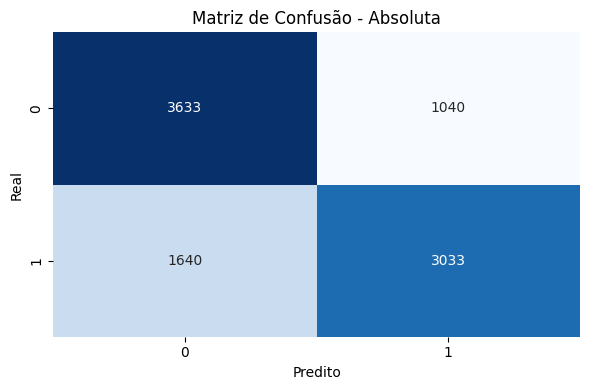

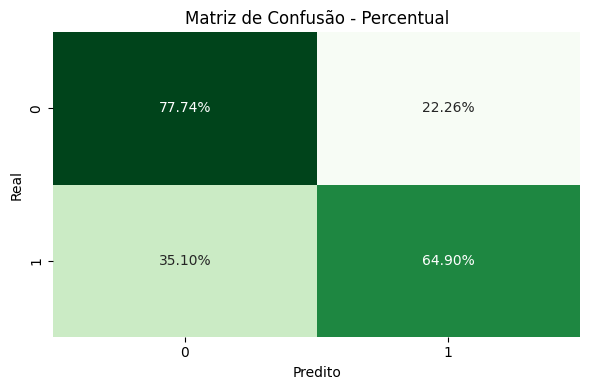

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


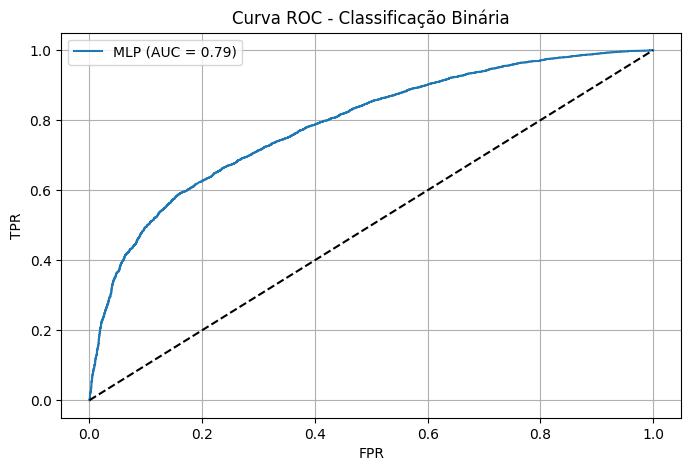

Pipeline finalizado com sucesso!


In [ ]:
run_mlp_model(df, target_column='y')